In [ ]:
from importlib import reload
from collections.abc import Callable

from matplotlib import pyplot as plt

import numpy as np
import jax
from jax import numpy as jnp

import base_system
import base_solver
import base_optim
import solvers
import utils

import kse

reload(base_system)
reload(base_solver)
reload(base_optim)
reload(solvers)
reload(utils)

reload(kse)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray
pi = jnp.pi

In [ ]:
def run_update(
    system: base_system.System,
    solver: base_solver.SinglestepSolver,
    dt: float,
    T0: float,
    Tf: float,
    t_relax: float,
    true0: jndarray,
    nudged0: jndarray,
    optimizer: Callable[[jndarray, jndarray], jndarray]
    | base_optim.Optimizer
    | None = None,
) -> tuple[jndarray, np.ndarray, np.ndarray]:
    """Implementation of `run_update` for non-multistep solvers (e.g., RK4),
    here referred to as 'singlestep' solvers. See documentation of `run_update`.
    """
    assert isinstance(solver, base_solver.SinglestepSolver)

    if optimizer is None:
        optimizer = base_optim.LevenbergMarquardt(system)

    cs = [system.cs]
    errors = []

    t0 = T0
    tf = t0 + t_relax
    while tf <= Tf:
        true, nudged, tls = solver.solve(true0, nudged0, t0, tf, dt)

        true0, nudged0 = true[-1], nudged[-1]

        # Update parameters
        system.cs = optimizer(true[-1][system.observed_slice], nudged[-1])
        cs.append(system.cs)

        t0 = tls[-1]
        tf = t0 + t_relax

        # Relative error
        errors.append(
            np.linalg.norm(true[1:] - nudged[1:]) / np.linalg.norm(true[1:])
        )

    errors = np.array(errors)

    # Note the last `t0` is the actual final time of the simulation.
    tls = np.linspace(T0, t0, len(errors) + 1)

    return jnp.stack(cs), errors, tls, true, nudged

In [ ]:
def get_initial_values(x0: float, xf: float, n: int):
    """Get initial values for the true and nudged states.

    Parameters
    ----------
    x0, xf
        Endpoints of domain
    n
        Number of spatial grid points on [x0, xf]

    Returns
    -------
    u0
        Initial true state
    un0
        Initial nudged state
    """
    L = xf - x0
    # L = 1

    # Initial true state
    # u = (
    #     lambda x: jnp.sin(6 * pi * x / L)
    #     + 0.1 * jnp.cos(pi * x / L)
    #     - 0.2 * jnp.sin(3 * pi * x / L)
    #     + 0.05 * jnp.cos(15 * pi * x / L)
    #     + 0.7 * jnp.sin(18 * pi * x / L)
    #     - jnp.cos(13 * pi * x / L)
    # )
    u = lambda x: jnp.sin(2 * pi * x / L)
    xls = jnp.linspace(x0, xf, n)
    u0 = u(xls)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def plot(c1s, c2s, c3s, u_errors, g1, g2, g3, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(g1, ils[0], ils[-1], label="g1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs g1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(g2, ils[0], ils[-1], label="g2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs g2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.hlines(g3, ils[0], ils[-1], label="g3", color="black")
    ax.plot(ils, c3s, label="c3")
    ax.legend()
    ax.set_title("c3 vs g3")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

Using Josh's initial condition (with the sum of cosines and sines) causes my true state to diverge very quickly.
Even when using a simple sine initial condition, the true state diverges after a while.
The internet suggests this system is chaotic (related to an reverse heat equation), so perhaps this is to be expected.

I haven't been able to recover the third parameter yet.

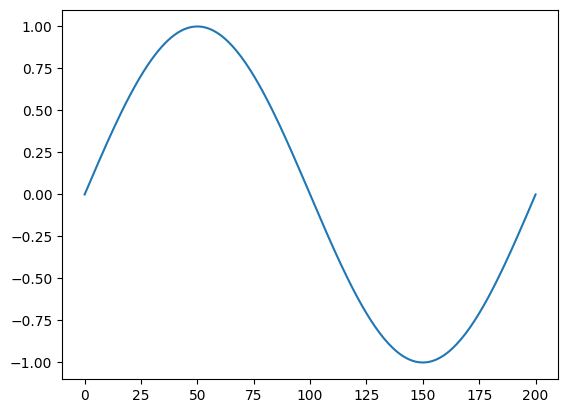

In [ ]:
# System evolution parameters
x0, xf = 0, 200
g1, g2, g3 = 1/2, 1/2, 1/2
c1, c2, c3 = g1, g2, g3
c1 *= 2
c2 *= 0.5
c3 *= 2
μ = 1

gs = jnp.array([g1, g2, g3], dtype=float)
bs = jnp.array([])
cs = jnp.array([c1, c2, c3], dtype=float)

observed_slice = jnp.s_[:]
system = kse.KSE(μ, gs, bs, cs, observed_slice, x0, xf)
solver = solvers.RK4(system)
solver = solvers.TwoStepAdamsBashforth(system, solver)
optimizer = base_optim.LevenbergMarquardt(system, 5)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 62
t_relax = 1
xn = 200

plt.plot(jnp.linspace(x0, xf, xn), get_initial_values(x0, xf, xn)[0])
plt.show()

cs, u_errors, tls = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(x0, xf, xn),
    optimizer,
)

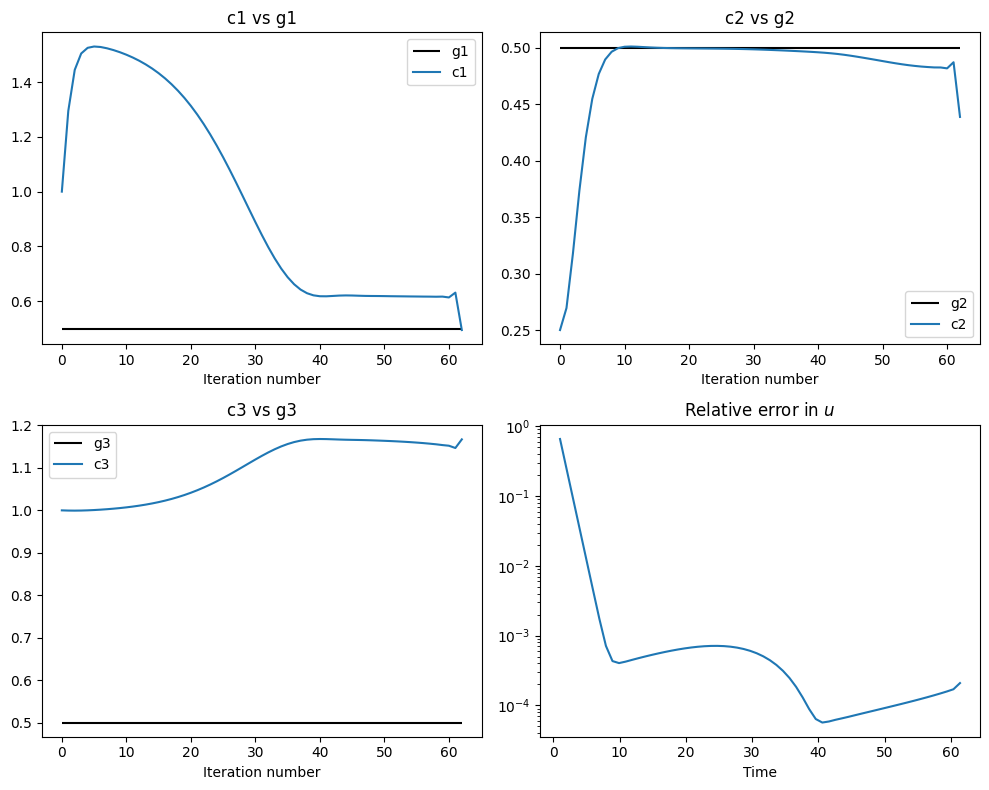

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], cs.T[2], u_errors, g1, g2, g3, tls)
plt.show()